In [3]:
import sys
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from IPython.display import display, HTML


In [4]:
def generate_chunk_html(df_chunk):
    html = df_chunk.to_html(classes='table table-striped', index=False)
    return html

def display_scrollable_table(df, chunk_size=100):
    html_output = "<div style='overflow: auto; max-height: 400px; width:100%;'>"
    for i in range(0, len(df), chunk_size):
        df_chunk = df[i:i + chunk_size] 
        html_output += generate_chunk_html(df_chunk)

    html_output += "</div>"
    display(HTML(html_output))

In [5]:
df = pd.read_csv('data/processed/train.csv')
model_epochs = 1024
model_batch_size = 64
log_file='log/log.txt'

In [6]:
# Normalize the data using QuantileTransformer

price_transformer = QuantileTransformer(n_quantiles=150)
df['SalePrice'] = price_transformer.fit_transform(df[['SalePrice']])

# Split the dataframe into features and target BEFORE scaling. This prevents leakage from your target variable.
x = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

# Fit transformer ONLY on training data.
transformer = QuantileTransformer(n_quantiles=150).fit(x_train.select_dtypes(include=['int64', 'float64']))

# Transform both training and test sets.
numerical_cols = x_train.select_dtypes(include=['int64', 'float64']).columns  # Get numerical columns from training set
x_train[numerical_cols] = transformer.transform(x_train[numerical_cols])
x_test[numerical_cols] = transformer.transform(x_test[numerical_cols])


In [7]:
def weighted_mse(y_true, y_pred):
    low_range = 0.25  # Define your lower range (scaled)
    weight_factor = 3.0  # Increase for higher penalty

    # Calculate the squared error
    squared_error = tf.square(y_true - y_pred)

    # Create a mask for the low ranges of interest
    mask_low = tf.logical_and(y_true >= 0, y_true <= low_range)

    # Apply weights
    weights = tf.where(mask_low, weight_factor, 1.0)  # Apply weight_factor if in range, else 1

    # Calculate the weighted squared error
    weighted_squared_error = weights * squared_error

    # Calculate the mean of the weighted squared error
    weighted_mse_loss = tf.reduce_mean(weighted_squared_error)

    return weighted_mse_loss

In [8]:
# Function for creating and compiling the model
def create_model(learning_rate=0.0001, dropout_rate=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(x_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='silu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='silu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='silu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(
    optimizer=tf.keras.optimizers.Lion(learning_rate=learning_rate),
    loss=weighted_mse,
    metrics=['mean_absolute_error', 'r2_score']
    )
    return model

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10, # Stop after 10 epochs with no improvement
    restore_best_weights=True, 
    verbose=1             
)

In [10]:
rmse_per_fold = []
mse_per_fold = []
r2_per_fold = []
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=50)
if os.path.isfile(log_file):
    os.remove(log_file)

for fold, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):  # Pass y_train to kf.split
    print(f'Fold {fold + 1}')

    # Split the data into training and validation sets for this fold
    x_train_fold = x_train.iloc[train_index]
    x_val_fold = x_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]

    # Create a new instance of the model for each fold
    model = create_model()

    # Train the model on the training fold
    original_stdout = sys.stdout  
    with open(log_file, 'a') as f:
        sys.stdout = f
        history = model.fit(
            x_train_fold,
            y_train_fold,
            epochs=model_epochs,
            batch_size=model_batch_size,
            verbose=1,
            validation_data=(x_val_fold, y_val_fold),  #Crucial:  Pass validation data
            callbacks=[early_stopping]  # Add the EarlyStopping callback
        )
        sys.stdout = original_stdout

    # Evaluate the model on the validation fold
    val_predictions = model.predict(x_val_fold)

    # Calculate RMSE, MSE and R-squared
    rmse = root_mean_squared_error(y_val_fold, val_predictions)
    mse = mean_squared_error(y_val_fold, val_predictions)
    r2 = r2_score(y_val_fold, val_predictions)

    # Store the metrics for this fold
    rmse_per_fold.append(rmse)
    mse_per_fold.append(mse)
    r2_per_fold.append(r2)
    print(f'RMSE for fold {fold + 1}: {rmse:.4f}')
    print(f'MSE for fold {fold + 1}: {mse:.4f}')
    print(f'R-squared for fold {fold + 1}: {r2:.4f}')

print('\n')
print(f'Average RMSE across {k} folds: {np.mean(rmse_per_fold):.4f}')
print(f'Average MSE across {k} folds: {np.mean(mse_per_fold):.4f}')
print(f'Average R-squared across {k} folds: {np.mean(r2_per_fold):.4f}')
print(f'Standard deviation of RMSE: {np.std(rmse_per_fold):.4f}')
print(f'Standard deviation of MSE: {np.std(mse_per_fold):.4f}')
print(f'Standard deviation of R-squared: {np.std(r2_per_fold):.4f}')

Fold 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RMSE for fold 1: 0.0942
MSE for fold 1: 0.0089
R-squared for fold 1: 0.8781
Fold 2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
RMSE for fold 2: 0.0786
MSE for fold 2: 0.0062
R-squared for fold 2: 0.9292
Fold 3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE for fold 3: 0.0783
MSE for fold 3: 0.0061
R-squared for fold 3: 0.9277
Fold 4
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
RMSE for fold 4: 0.0908
MSE for fold 4: 0.0082
R-squared for fold 4: 0.9002
Fold 5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RMSE for fold 5: 0.0887
MSE for fold 5: 0.0079
R-squared for fold 5: 0.9110


Average RMSE across 5 folds: 0.0861
Average MSE across 5 folds: 0.0075
Average R-squared across 5 folds: 0.9092
Standard deviation of RMSE: 0.0065
Standard deviation of MSE: 0.0011
Standard deviation of R-squared: 0.0190


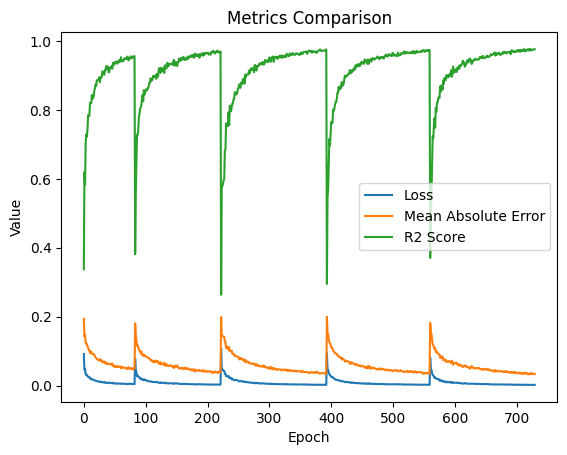

In [11]:
with open(log_file, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

loss = []
mae = []
r2 = []
for line in lines:
    if 'loss:' in line and 'mean_absolute_error:' in line and 'r2_score' in line and 'm15/15' in line:
        match = re.search(r'loss: (\d+\.\d+) - mean_absolute_error: (\d+\.\d+) - r2_score: (\d+\.\d+)', line)
        if match:
            loss.append(float(match.group(1)))
            mae.append(float(match.group(2)))
            r2.append(float(match.group(3)))

df_metrics = pd.DataFrame({'loss': loss, 'mean_absolute_error': mae, 'r2_score': r2})
plt.plot(df_metrics['loss'], label='Loss')
plt.plot(df_metrics['mean_absolute_error'], label='Mean Absolute Error')
plt.plot(df_metrics['r2_score'], label='R2 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Metrics Comparison')
plt.legend()
plt.show()

In [12]:
# Create a matplotlib chart to compare predicted and actual values

model = create_model()

model.fit(
    x_train,
    y_train,
    epochs=model_epochs,
    batch_size=model_batch_size,
    verbose=0,
    callbacks=[early_stopping]
)


Epoch 211: early stopping
Restoring model weights from the end of the best epoch: 201.


In [13]:
y_pred = model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [14]:
rmse = root_mean_squared_error(y_test, y_pred)
rmse_percentaje = rmse / y_test.mean() * 100
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'RMSE %: {rmse_percentaje:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

RMSE: 0.0822
RMSE %: 16.3388
MSE: 0.0068
R-squared: 0.9228


In [15]:
model.save(f'model/{rmse:.2f}-{rmse_percentaje:.2f}-{mse:.2f}-{r2:.2f}.keras')

In [16]:
y_pred_unscaled = price_transformer.inverse_transform(y_pred)
y_test_unscaled = price_transformer.inverse_transform(y_test.to_numpy().reshape(-1, 1))

c:\Users\Alumno_AI\Desktop\housing_price_prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\Alumno_AI\Desktop\housing_price_prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [17]:
print("\nPredicted vs. Actual Prices:")

predictions_df = pd.DataFrame({
    'Predicted': y_pred_unscaled.flatten(),
    'Actual': y_test_unscaled.flatten(),
    'Difference': y_pred_unscaled.flatten() - y_test_unscaled.flatten(),
    'Percentage': (y_pred_unscaled.flatten() - y_test_unscaled.flatten()) / y_test_unscaled.flatten() * 100
})

predictions_df['Percentage'] = predictions_df['Percentage'].abs()

display_scrollable_table(predictions_df.sort_values(by='Percentage', ascending=True))


Predicted vs. Actual Prices:


Predicted,Actual,Difference,Percentage
340037.500000,340037.5,0.000000,0.000000
340037.500000,340037.5,0.000000,0.000000
340037.500000,340037.5,0.000000,0.000000
340037.500000,340037.5,0.000000,0.000000
340037.500000,340037.5,0.000000,0.000000
94442.929688,94500.0,-57.070312,0.060392
259595.421875,260000.0,-404.578125,0.155607
179314.140625,179000.0,314.140625,0.175498
213576.218750,214000.0,-423.781250,0.198029
170618.171875,171000.0,-381.828125,0.223291


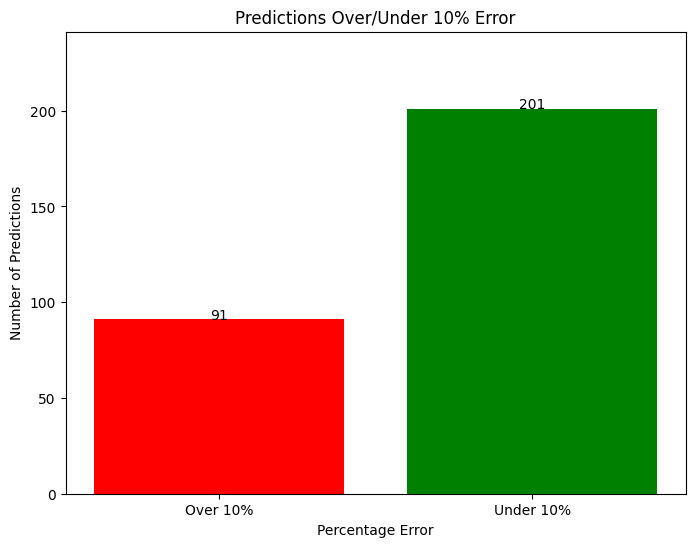

In [18]:
over_10_percent = predictions_df[predictions_df['Percentage'] > 10].shape[0]
under_10_percent = predictions_df[predictions_df['Percentage'] <= 10].shape[0]

labels = ['Over 10%', 'Under 10%']
counts = [over_10_percent, under_10_percent]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['red', 'green'])
plt.xlabel('Percentage Error')
plt.ylabel('Number of Predictions')
plt.title('Predictions Over/Under 10% Error')
plt.ylim(0, max(counts) * 1.2)
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.show()

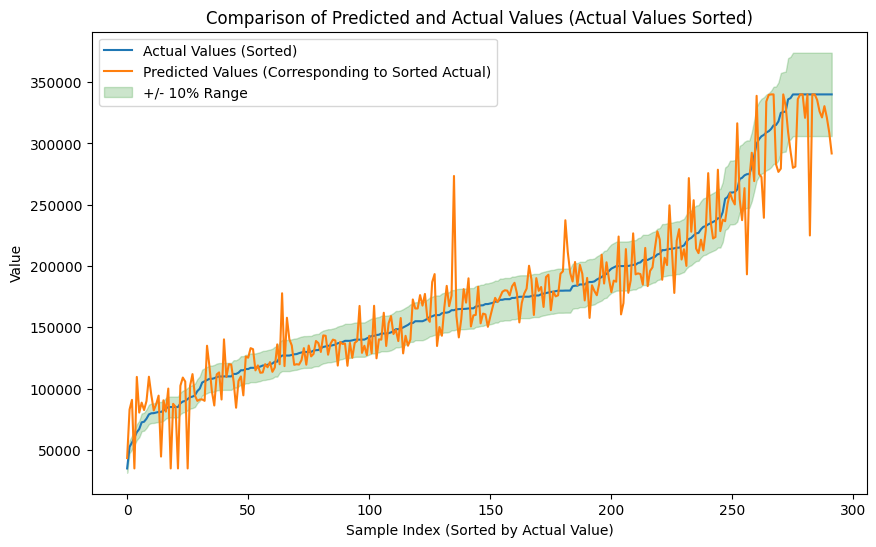

In [19]:
data = list(zip(y_test_unscaled.flatten(), y_pred_unscaled.flatten(), range(len(y_test_unscaled))))

# Sort data
data.sort(key=lambda x: x[0])
y_test_sorted = np.array([item[0] for item in data])
y_pred_sorted = np.array([item[1] for item in data])
original_indices = np.array([item[2] for item in data]) 

plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted, label='Actual Values (Sorted)')
plt.plot(y_pred_sorted, label='Predicted Values (Corresponding to Sorted Actual)')

plt.fill_between(
    range(len(y_test_sorted)),
    y_test_sorted * 0.9,  # Lower bound (actual - 10%)
    y_test_sorted * 1.1,  # Upper bound (actual + 10%)
    color='green',
    alpha=0.2,
    label='+/- 10% Range'
)

plt.xlabel('Sample Index (Sorted by Actual Value)')
plt.ylabel('Value')
plt.title('Comparison of Predicted and Actual Values (Actual Values Sorted)')
plt.legend()
plt.show()

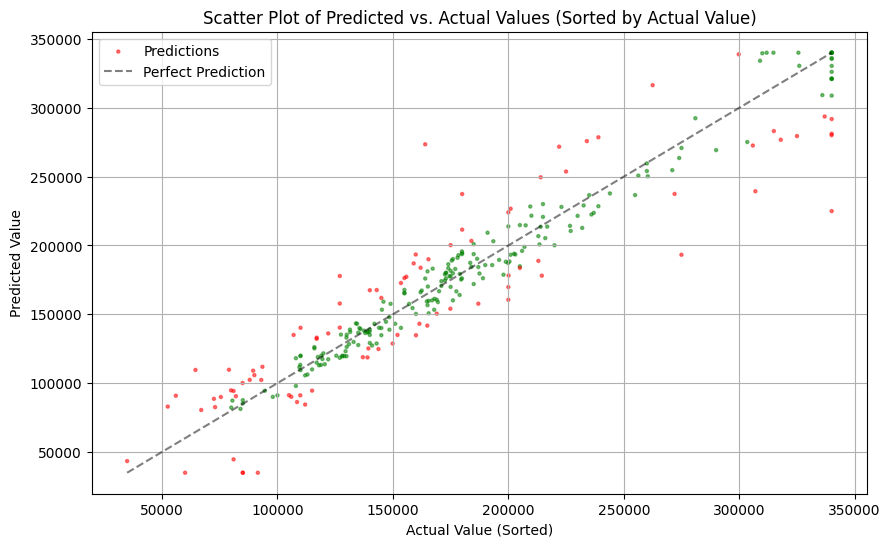

In [20]:
data = list(zip(y_test_unscaled.flatten(), y_pred_unscaled.flatten(), range(len(y_test_unscaled))))

# Sort data
data.sort(key=lambda x: x[0])
y_test_sorted = np.array([item[0] for item in data])
y_pred_sorted = np.array([item[1] for item in data])
original_indices = np.array([item[2] for item in data])


# Determine colors based on the 10% range
colors = []
for i in range(len(y_test_sorted)):
    if y_pred_sorted[i] >= y_test_sorted[i] * 0.9 and y_pred_sorted[i] <= y_test_sorted[i] * 1.1:
        colors.append('green')  # Within +/- 10%
    else:
        colors.append('red')  # Outside +/- 10%

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sorted, y_pred_sorted, c=colors, label='Predictions', s=5, alpha=0.5)  # Reduced size, added alpha

# Add a line of perfect prediction for reference
min_val = min(np.min(y_test_sorted), np.min(y_pred_sorted))
max_val = max(np.max(y_test_sorted), np.max(y_pred_sorted))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Prediction') # black dashed line

plt.xlabel('Actual Value (Sorted)')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Predicted vs. Actual Values (Sorted by Actual Value)')
plt.legend()
plt.grid(True)

plt.show()

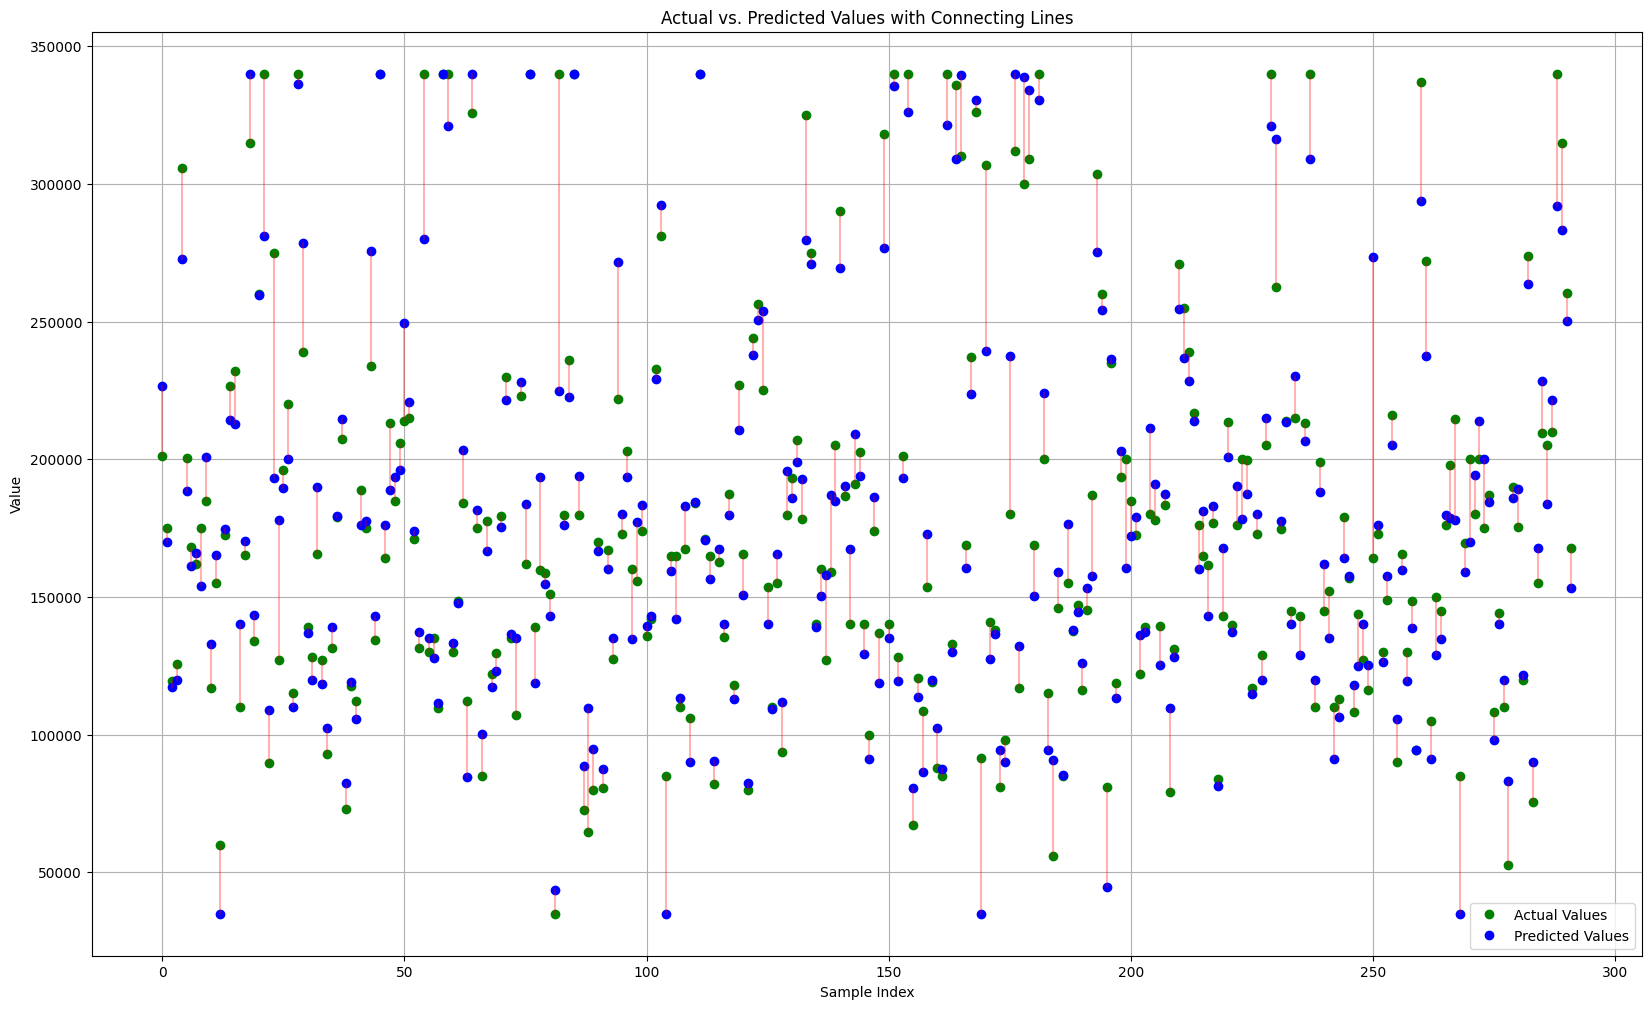

In [21]:
# Create the plot
plt.figure(figsize=(20, 12))

# Plot actual values (green circles)
plt.plot(range(len(y_test_unscaled)), y_test_unscaled, 'go', label='Actual Values')

# Plot predicted values (blue circles)
plt.plot(range(len(y_pred_unscaled)), y_pred_unscaled, 'bo', label='Predicted Values')

# Connect actual and predicted values with lines
for i in range(len(y_test_unscaled)):
    plt.plot([i, i], [y_test_unscaled[i], y_pred_unscaled[i]], 'r-', alpha=0.3)  # Red lines

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values with Connecting Lines')
plt.legend()
plt.grid(True)
plt.show()